<h1></h1>
<h2><center> ETI195 - Ética para Ciencia de Datos y Estadística </center></h2>

<h1></h1>
<h2><center> Taller 4: AIF360 </center></h2>

![AIF360](https://opengraph.githubassets.com/4b7ff9fccf4e6cafd9e59f42921b31a0f7f6696b009c8519e584be278094769d/Trusted-AI/AIF360)

In [ ]:
# Instalar la librería AIF360

# En Google Colab:
# Utilice el comando mágico %pip para instalar la librería.
# %pip install aif360
# o
# %pip install aif360[all]

# En una terminal de consola:

# Ejecute el siguiente comando para instalar la librería.
# pip install aif360
# Para instalar todas las dependencias opcionales, usar:
# pip install aif360[all]

Tiene el siguiente GitHub:

[AIF360](https://github.com/Trusted-AI/AIF360)

## Import de librerías


In [ ]:
# elementales

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

palette = ["#f04498", "#8881c7"]
import seaborn as sns

# sklearn

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
)

# aif360

from aif360.sklearn.datasets import fetch_german
from aif360.algorithms.preprocessing import Reweighing
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

## Obtención y manipulación de los datos

Estaremos utilizando el dataset 'German Credit Data', uno de los más utilizados en el área para demostrar la eficiencia de las distintas técnicas de debiasing.

In [3]:
# Obtenemos los datos.

X, y = fetch_german() # type: ignore
X.head()

checking_status  duration  \
sex    age   foreign_worker                             
male   aged  yes                         <0         6   
female young yes                   0<=X<200        48   
male   aged  yes                no checking        12   
             yes                         <0        42   
             yes                         <0        24   

                                             credit_history  \
sex    age   foreign_worker                                   
male   aged  yes             critical/other existing credit   
female young yes                              existing paid   
male   aged  yes             critical/other existing credit   
             yes                              existing paid   
             yes                         delayed previously   

                                         purpose  credit_amount  \
sex    age   foreign_worker                                       
male   aged  yes                        radio/tv           1169   
female young yes                        radio/tv           5951   
male   aged  yes                       education           2096   
             yes             furniture/equipment           7882   
             yes                         new car           4870   

                               savings_status employment  \
sex    age   foreign_worker                                
male   aged  yes             no known savings        >=7   
female young yes                         <100     1<=X<4   
male   aged  yes                         <100     4<=X<7   
             yes                         <100     4<=X<7   
             yes                         <100     1<=X<4   

                             installment_commitment other_parties  \
sex    age   foreign_worker                                         
male   aged  yes                                  4          none   
female young yes                                  2          none   
male   aged  yes                                  2          none   
             yes                                  2     guarantor   
             yes                                  3          none   

                             residence_since  ... age  other_payment_plans  \
sex    age   foreign_worker                   ...                            
male   aged  yes                           4  ...  67                 none   
female young yes                           2  ...  22                 none   
male   aged  yes                           3  ...  49                 none   
             yes                           4  ...  45                 none   
             yes                           4  ...  53                 none   

                              housing existing_credits                 job  \
sex    age   foreign_worker                                                  
male   aged  yes                  own                2             skilled   
female young yes                  own                1             skilled   
male   aged  yes                  own                1  unskilled resident   
             yes             for free                1             skilled   
             yes             for free                2             skilled   

                            num_dependents  own_telephone foreign_worker  \
sex    age   foreign_worker                                                
male   aged  yes                         1            yes            yes   
female young yes                         1           none            yes   
male   aged  yes                         2           none            yes   
             yes                         2           none            yes   
             yes                         2           none            yes   

                                sex marital_status  
sex    age   foreign_worker                         
male   aged  yes               male         single  
female young yes         

In [4]:
# Los manipularemos para dejarlos en el formato habitual.

df = (
    pd.concat([X, y], axis=1)
    .drop(columns=["sex", "foreign_worker"])
    .rename(columns={"age": "age_numeric"})
    .reset_index()
)
df.head()

,sex,age,foreign_worker,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,...,property_magnitude,age_numeric,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,marital_status,credit-risk
0,male,aged,yes,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,...,real estate,67,none,own,2,skilled,1,yes,single,good
1,female,young,yes,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,...,real estate,22,none,own,1,skilled,1,none,div/dep/mar,bad
2,male,aged,yes,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,...,real estate,49,none,own,1,unskilled resident,2,none,single,good
3,male,aged,yes,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,...,life insurance,45,none,for free,1,skilled,2,none,single,good
4,male,aged,yes,<0,24,delayed previously,new car,4870,<100,1<=X<4,...,no known property,53,none,for free,2,skilled,2,none,single,bad


In [ ]:
df = df.rename(columns={"age": "age_cat", "age_numeric": "age"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   sex                     1000 non-null   category
 1   age_cat                 1000 non-null   category
 2   foreign_worker          1000 non-null   category
 3   checking_status         1000 non-null   category
 4   duration                1000 non-null   int64   
 5   credit_history          1000 non-null   category
 6   purpose                 1000 non-null   category
 7   credit_amount           1000 non-null   int64   
 8   savings_status          1000 non-null   category
 9   employment              1000 non-null   category
 10  installment_commitment  1000 non-null   int64   
 11  other_parties           1000 non-null   category
 12  residence_since         1000 non-null   int64   
 13  property_magnitude      1000 non-null   category
 14  age                     1

### Descripción de las columnas.

**Atributos Numéricos**

- `duration`: Duración en meses. Rango (4,72).
- `credit_amount`: Cantidad de crédito solicitada. Rango (250, 18424) en DM - Marco alemán.
- `installment_commitment`: Tasa de cuota en porcentaje del ingreso disponible. Rango (1,4).
- `residence_since`: Tiempo de residencia actual. Rango (1,4).
- `age`: Edad en años. Rango (19, 75).
- `existing_credits`: Número de créditos existentes en este banco. Rango (1,4) en DM - Marco alemán.
- `num_dependents`: Número de personas responsables de proveer el mantenimiento. Rango (1,2).

**Atributos Categóricos**

- `checking_status`: Valores `'0<=X<200', '<0', '>=200', 'no checking'`.
- `credit_history`: Historial crediticio del solicitante. Valores `['all paid', 'critical/other existing credit', 'delayed previously', 'existing paid', 'no credits/all paid']`.
- `purpose`: Motivo por el cual el solicitante solicitó un préstamo. Valores `['business', 'domestic appliance', 'education', 'furniture/equipment', 'new car', 'other', 'radio/tv', 'repairs', 'retraining', 'used car']`.
- `savings_status`: Cuenta de ahorros/bonos. Valores `['100<=X<500', '500<=X<1000', '<100', '>=1000', 'no known savings']`.
- `employment`: Empleo actual desde (en años). Valores `['1<=X<4', '4<=X<7', '<1', '>=7', 'unemployed']`.
- `other_parties`: Otros deudores / garantes. Valores `['co applicant', 'guarantor', 'none']`.
- `property_magnitude`: Bienes del solicitante. Valores `['car', 'life insurance', 'no known property', 'real estate']`.
- `other_payment_plans`: Otros planes de pago a plazos. Valores `['bank', 'none', 'stores']`.
- `housing`: Situación de vivienda del solicitante. Valores `['for free', 'own', 'rent']`.
- `job`: Categorías de empleo definidas por el banco. Valores `['high qualif/self emp/mgmt', 'skilled', 'unemp/unskilled non res', 'unskilled resident']`.
- `own_telephone`: Si hay un teléfono registrado a nombre del cliente. Valores `['none', 'yes']`.
- `foreign_worker`: **Atributo protegido**. Valores `['no', 'yes']`.
- `sex`: **Atributo protegido**. Valores `['female', 'male']`.
- `marital_status`: Estado civil. Valores `['div/dep/mar', 'div/sep', 'mar/wid', 'single']`.

**Etiqueta**

- `credit-risk`: `'good'` (favorable) o `'bad'` (desfavorable).

## Análisis exploratorio.

Es importante que conozcamos las características de los datos con los que estamos trabajando.

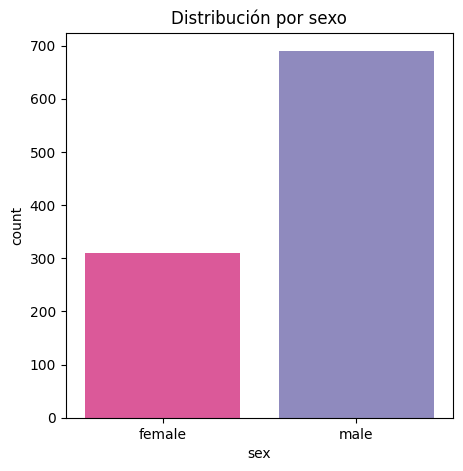

In [6]:
# Distribución por sexo

fig, ax = plt.subplots(1, figsize=(5, 5))
sns.countplot(data=df, x="sex", hue="sex", palette=palette, legend=False)
ax.set_title("Distribución por sexo")
plt.show()

In [7]:
df["sex"].value_counts(normalize=True) * 100

sex
male      69.0
female    31.0
Name: proportion, dtype: float64

**Pregunta**: Vemos que existe un desbalanceo importante en la representación por género. ¿Qué consecuencias podría tener esto en nuestro modelo?

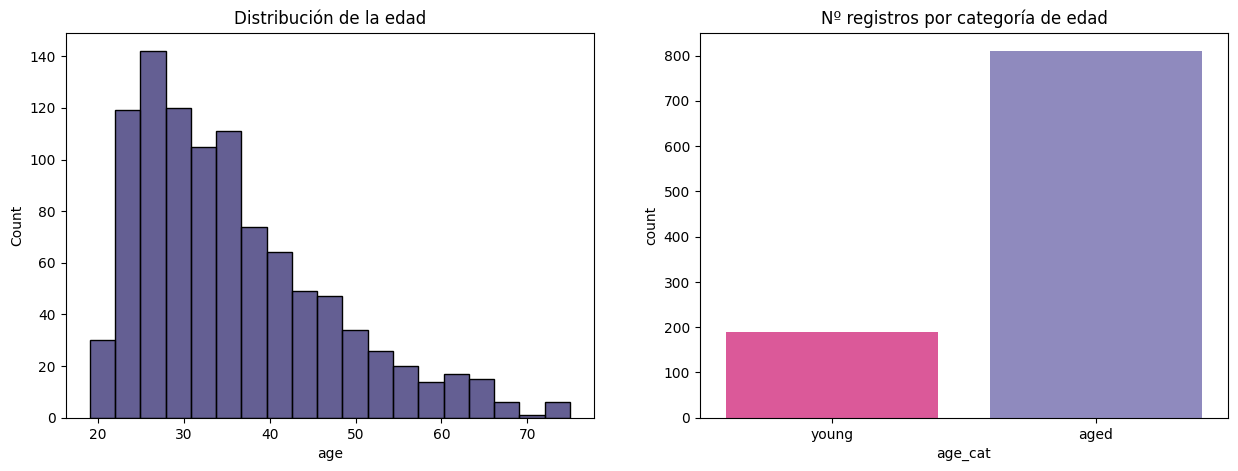

In [8]:
# Distribución de la edad

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax = ax.flatten()

sns.histplot(data=df, x="age", color="#30296f", ax=ax[0])
sns.countplot(
    data=df, x="age_cat", ax=ax[1], hue="age_cat", palette=palette, legend=False
)

ax[0].set_title("Distribución de la edad")
ax[1].set_title("Nº registros por categoría de edad")
plt.show()

In [9]:
# Interseccionalidad

# Interseccionalidad sexo-edad. Proporción respecto del total

pd.crosstab(
    values=df["credit-risk"],
    columns=df["sex"],
    index=df["age_cat"],
    aggfunc=lambda x: len(x),
    normalize="all",
) * 100

sex,female,male
age_cat,,
young,10.5,8.5
aged,20.5,60.5


Vemos que los hombres adultos (>= 25 años) representan más del 60% de los datos, mientras que las mujeres adultas representan el 20% de los datos.

In [10]:
# Desglose de los grupos etáreos según sexo.

pd.crosstab(
    values=df["credit-risk"],
    columns=df["sex"],
    index=df["age_cat"],
    aggfunc=lambda x: len(x),
    normalize="index",
) * 100

sex,female,male
age_cat,,
young,55.263158,44.736842
aged,25.308642,74.691358


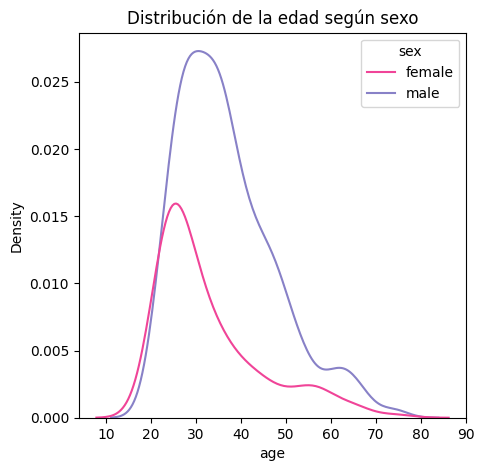

In [11]:
# Distribución de la edad según sexo

fig, ax = plt.subplots(1, figsize=(5, 5))
sns.kdeplot(data=df, x="age", hue="sex", palette=palette)
ax.set_title("Distribución de la edad según sexo")
plt.show()

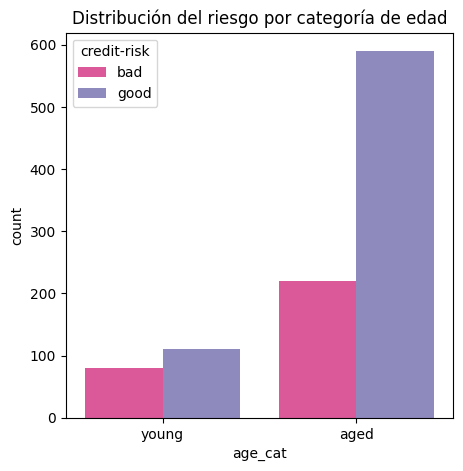

In [12]:
# Distribución de la variable objetivo por edad

fig, ax = plt.subplots(1, figsize=(5, 5))
sns.countplot(data=df, x="age_cat", hue="credit-risk", palette=palette)
ax.set_title("Distribución del riesgo por categoría de edad")
plt.show()

In [13]:
# Desglose de los grupos etáreos según categoría de riesgo.

pd.crosstab(
    values=df["credit-risk"],
    columns=df["credit-risk"],
    index=df["age_cat"],
    aggfunc=lambda x: len(x),
    normalize="index",
) * 100

credit-risk,bad,good
age_cat,,
young,42.105263,57.894737
aged,27.160494,72.839506


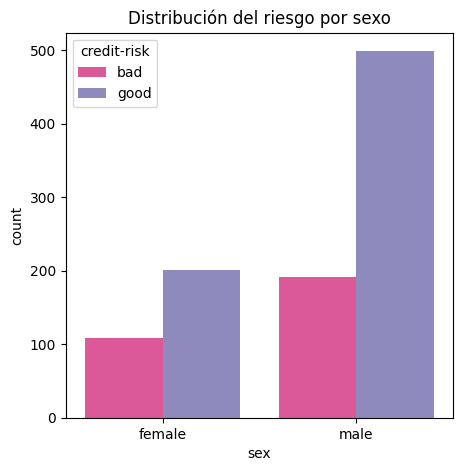

In [14]:
# Distribución de la variable objetivo por sexo

fig, ax = plt.subplots(1, figsize=(5, 5))
sns.countplot(data=df, x="sex", hue="credit-risk", palette=palette)
ax.set_title("Distribución del riesgo por sexo")
plt.show()

In [15]:
# Desglose del sexo según categoría de riesgo.

pd.crosstab(
    values=df["credit-risk"],
    columns=df["credit-risk"],
    index=df["sex"],
    aggfunc=lambda x: len(x),
    normalize="index",
) * 100

credit-risk,bad,good
sex,,
female,35.161290,64.838710
male,27.681159,72.318841


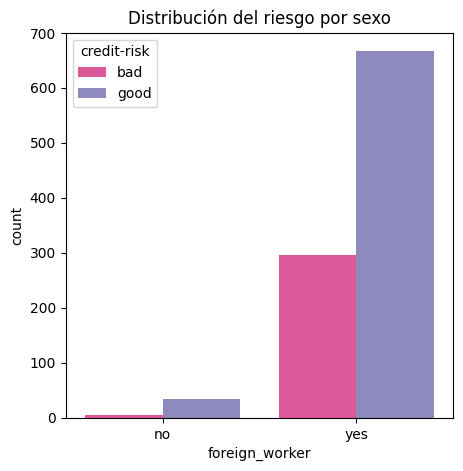

In [16]:
# Distribución de la variable objetivo en trabajadores extranjeros.

fig, ax = plt.subplots(1, figsize=(5, 5))
sns.countplot(data=df, x="foreign_worker", hue="credit-risk", palette=palette)
ax.set_title("Distribución del riesgo por sexo")
plt.show()

In [17]:
pd.crosstab(
    values=df["credit-risk"],
    columns=df["credit-risk"],
    index=df["foreign_worker"],
    aggfunc=lambda x: len(x),
    normalize="index",
) * 100

credit-risk,bad,good
foreign_worker,,
no,10.810811,89.189189
yes,30.737279,69.262721


**Pregunta**: ¿Tenemos discriminación hacia algún grupo en nuestros datos? Si es así, ¿estamos dispuestos a continuar con el entrenamiento de un modelo utilizando estos datos?

## Pre-procesamiento

Haremos el pre-procesamiento de nuestros datos para poder trabajar con los algoritmos.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   sex                     1000 non-null   category
 1   age_cat                 1000 non-null   category
 2   foreign_worker          1000 non-null   category
 3   checking_status         1000 non-null   category
 4   duration                1000 non-null   int64   
 5   credit_history          1000 non-null   category
 6   purpose                 1000 non-null   category
 7   credit_amount           1000 non-null   int64   
 8   savings_status          1000 non-null   category
 9   employment              1000 non-null   category
 10  installment_commitment  1000 non-null   int64   
 11  other_parties           1000 non-null   category
 12  residence_since         1000 non-null   int64   
 13  property_magnitude      1000 non-null   category
 14  age                     1

In [19]:
# Binarización de algunas variables.

# Es importante establecer qué consideraremos 1 o 0 dependiendo de nuestros datos y su distribución.

df["sex"] = df["sex"].map({"male": 1, "female": 0})
df["age_cat"] = df["age_cat"].map({"aged": 1, "young": 0})
df["foreign_worker"] = df["foreign_worker"].map({"no": 1, "yes": 0})
df["credit-risk"] = df["credit-risk"].map({"good": 1, "bad": 0})

In [20]:
# Separamos X e Y.

X = df.loc[:, df.columns != "credit-risk"]
y = df.loc[:, df.columns == "credit-risk"]

In [21]:
df1 = X.copy()

In [22]:
# Obtenemos variables dummies

ignore = ["sex", "age_cat", "foreign_worker"]
for catcol in df1.select_dtypes(include="category").columns:
    if catcol in ignore:
        pass
    else:
        dummies = pd.get_dummies(X[catcol])
        X = pd.concat([X, dummies], axis=1).drop(columns=[catcol])

X.head()

,sex,age_cat,foreign_worker,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,...,high qualif/self emp/mgmt,unemp/unskilled non res,unskilled resident,skilled,none,yes,div/dep/mar,div/sep,mar/wid,single
0,1,1,0,6,1169,4,4,67,2,1,...,False,False,False,True,False,True,False,False,False,True
1,0,0,0,48,5951,2,2,22,1,1,...,False,False,False,True,True,False,True,False,False,False
2,1,1,0,12,2096,2,3,49,1,2,...,False,False,True,False,True,False,False,False,False,True
3,1,1,0,42,7882,2,4,45,1,2,...,False,False,False,True,True,False,False,False,False,True
4,1,1,0,24,4870,3,4,53,2,2,...,False,False,False,True,True,False,False,False,False,True


In [23]:
# Datos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=908
)

In [24]:
# No utilizaremos la edad (en su versión numérica)

X_train.drop(columns=["age"], inplace=True)
X_test.drop(columns=["age"], inplace=True)

## ¿Discriminación en nuestros datos?

Volvamos a la pregunta sobre si tenemos discriminación o no en nuestros datos. Una forma de medir la discriminación en nuestros datos es a través de AIF360, que nos facilita el cálculo de métricas. Para ello debemos seguir una serie de pasos para instanciar un BinaryLabelDatasetMetric.

- #### **Statistical Parity Difference**.

Corresponde a la diferencia entre la probabilidad de pertenecer a la clase positiva dado que se pertenece a la clase no privilegiada y  la probabilidad de pertenecer a la clase positiva dado que se pertenece a la clase privilegiada, es decir:

$SP = Pr(Y = 1 | D = \text{unprivileged})- Pr(Y = 1 | D = \text{privileged})$

Valores negativos de esta métrica podrían indicar la presencia de sesgo.

- #### **Disparate Impact**.

Es una métrica para medir fairness que compara la proporción de individuos que reciben un resultado positivo para el grupo privilegiado y el grupo no privilegiado. El cálculo es la proporción del grupo no privilegiado que recibe un resultado positivo dividida por la proporción del grupo privilegiado que recibe un resultado positivo.


$DI = \frac{Pr(Y = 1 | D = \text{unprivileged})}{Pr(Y = 1 | D = \text{privileged})}$



In [25]:
# Necesitamos los datos de entrenamiento en conjunto con la etiqueta.

df_train = X_train.copy()
df_train["credit-score"] = y_train

### Discriminación por edad

In [26]:
# Debemos definir nuestros grupos privilegiados y no privilegiados.

privileged_groups = [{"age_cat": 1}]  # Aged
unprivileged_groups = [{"age_cat": 0}]  # Young

In [27]:
# Instanciamos BinaryLabelDataset con edad como atributo protegido

attributes_params = dict(
    protected_attribute_names=["age_cat"], label_names=["credit-score"]
)
dt_train = BinaryLabelDataset(df=df_train, **attributes_params) # type: ignore

In [28]:
# Finalmente, la instancia de BinaryLabelDatasetMetric con la edad como atributo protegido.

metric_age_train = BinaryLabelDatasetMetric(
    dt_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

#### Métricas

In [29]:
print(
    f"Train Statistical Parity Difference (age): {metric_age_train.mean_difference()}"
)

Train Statistical Parity Difference (age): -0.13278706925580863


### Discriminación por sexo

In [30]:
# Debemos definir nuestros grupos privilegiados y no privilegiados.

privileged_groups = [{"sex": 1}]  # Male
unprivileged_groups = [{"sex": 0}]  # Female

In [31]:
# Instanciamos BinaryLabelDataset con el sexo como atributo protegido

attributes_params = dict(
    protected_attribute_names=["sex"], label_names=["credit-score"]
)
dt_train = BinaryLabelDataset(df=df_train, **attributes_params) # type: ignore

In [32]:
# Finalmente, la instancia de BinaryLabelDatasetMetric con el sexo como atributo protegido.

metric_sex_train = BinaryLabelDatasetMetric(
    dt_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

#### Métricas

In [33]:
print(
    f"Train Statistical Parity Difference (sex): {metric_sex_train.mean_difference()}"
)

Train Statistical Parity Difference (sex): -0.07291388962943213


**Pregunta**: Las métricas nos indican que existe sesgo con respecto al sexo y a la edad en nuestros datos de entrenamiento. Supongamos que entrenamos un modelo con estos datos. ¿Qué sucederá con estos sesgos dentro del modelo? ¿Serán replicados, ignorados o amplificados?

## Entrenamiento del modelo base

Estaremos utilizando una Regresión Logística como modelo base.

In [34]:
# Regresión logística

lr = LogisticRegressionCV(solver="liblinear", cv=10, random_state=908)
lr.fit(X_train, np.ravel(y_train))

LogisticRegressionCV(cv=10, random_state=908, solver='liblinear')

In [35]:
# Métricas modelo base

y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = y_pred_proba >= 0.5

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Accuracy: 0.74
Recall: 0.8686131386861314
F1: 0.8206896551724138


### Sesgo del modelo base

In [36]:
df_test = X_test.copy()
df_test["credit-score"] = y_pred

In [37]:
# Para facilitar el proceso

def get_aif_metrics(attr, df):

    privileged_groups = [{attr: 1}]
    unprivileged_groups = [{attr: 0}]

    attributes_params = dict(
        protected_attribute_names=[attr], label_names=["credit-score"]
    )
    dt = BinaryLabelDataset(df=df, **attributes_params) # type: ignore

    metric = BinaryLabelDatasetMetric(
        dt, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
    )

    return metric

#### Discriminación por sexo

In [38]:
metric_sex_test = get_aif_metrics("sex", df_test)
print(f"Test Statistical Parity Difference (sex): {metric_sex_test.mean_difference()}")
print(f"Test Disparate Impact (sex): {metric_sex_test.disparate_impact()}")

Test Statistical Parity Difference (sex): -0.1564171122994653
Test Disparate Impact (sex): 0.8088235294117646


#### Discriminación por edad

In [39]:
metric_sex_test = get_aif_metrics("age_cat", df_test)
print(f"Test Statistical Parity Difference (age): {metric_sex_test.mean_difference()}")
print(f"Test Disparate Impact (age): {metric_sex_test.disparate_impact()}")

Test Statistical Parity Difference (age): -0.2814142379359771
Test Disparate Impact (age): 0.6567599067599067


**Pregunta**: ¿Cómo es el sesgo de las predicciones de nuestro modelo respecto del sesgo presente en los datos de entrenamiento? Volvemos a una pregunta anterior: Ya evaluado el sesgo de este modelo ¿Lo implementarías? ¿Consideras importante que las métricas de sesgo formen parte de la evaluación del modelo?

## Mitigación del sesgo en los datos de entrenamiento: Métodos de pre-procesamiento.

Podemos implementar técnicas para la mitigación del sesgo en distintas etapas del ciclo de vida de nuestro modelo: contamos con algoritmos de pre-processing, in-processing y post-processing. En este taller nos enfocaremos en las técnicas de pre-procesamiento.

Los algoritmos de preprocesamiento tienden a cambiar las distribuciones de las variables protegidas en las muestras, o en términos más amplios, aplican cambios particulares a los datos para eliminar cualquier sesgo **en los datos de entrenamiento**. Estos cambios podrían ser, por ejemplo, cambiar la etiqueta de ciertos registros. El concepto fundamental es entrenar un modelo utilizando un conjunto de datos que ha sido "corregido".

En particular, estaremos aplicando la tecnica de **Reweighing**. Esta es una técnica de pre-procesamiento de datos que genera pesos para cada tupla según la combinación (grupo, etiqueta), para intentar mitigar el sesgo con respecto a los atributos sensibles antes de la clasificación.


**Pregunta**: Supongamos que estamos encargados de defender los intereses del banco. En ese sentido, ¿qué podría interesarnos que se mantuviese constante a pesar de las intervenciones?

En primer lugar, veamos como el Reweighing puede ayudar a eliminar el sesgo en los datos de entrenamiento.

In [40]:
# Originalmente todas las tuplas tienen peso 1.

dt_train.instance_weights

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

En este caso, estaremos enfocados en aplicar esta técnica para disminuir el sesgo con respecto a la categoría de edad.

In [41]:
# Debemos definir nuestros grupos privilegiados y no privilegiados.

privileged_groups = [{"age_cat": 1}]
unprivileged_groups = [{"age_cat": 0}]

# Instanciamos BinaryLabelDataset con edad como atributo protegido

attributes_params = dict(
    protected_attribute_names=["age_cat"], label_names=["credit-score"]
)
dt_train = BinaryLabelDataset(df=df_train, **attributes_params) # type: ignore

# Instanciamos algoritmo de Reweighing

reweight = Reweighing(
    unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups
)

# Obtenemos los nuevos datos de entrenamiento (en formato BinaryLabelDataset)

reweighted = reweight.fit_transform(dt_train)

In [42]:
# Veamos que los pesos han cambiado

reweighted.instance_weights

array([1.09242188, 1.18073611, 1.09242188, 0.96561047, 1.09242188,
       0.96561047, 1.09242188, 1.18073611, 0.73334016, 0.96561047,
       0.96561047, 0.96561047, 0.96561047, 0.96561047, 0.96561047,
       1.09242188, 0.96561047, 0.96561047, 1.09242188, 0.96561047,
       0.96561047, 0.96561047, 0.73334016, 0.96561047, 0.96561047,
       0.96561047, 1.09242188, 0.96561047, 0.96561047, 0.96561047,
       1.09242188, 1.09242188, 1.18073611, 0.96561047, 1.09242188,
       0.96561047, 0.96561047, 0.96561047, 1.09242188, 0.96561047,
       1.09242188, 1.09242188, 1.18073611, 0.96561047, 1.09242188,
       0.96561047, 1.18073611, 1.18073611, 0.96561047, 0.96561047,
       0.96561047, 0.96561047, 1.09242188, 0.96561047, 0.96561047,
       1.09242188, 1.09242188, 0.96561047, 0.73334016, 0.96561047,
       1.09242188, 0.96561047, 0.96561047, 0.73334016, 1.09242188,
       1.09242188, 0.96561047, 0.96561047, 0.96561047, 0.96561047,
       0.96561047, 1.09242188, 0.73334016, 0.96561047, 0.96561

In [43]:
# Miremos las métricas para estos datos

reweighted_metrics = BinaryLabelDatasetMetric(
    reweighted,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups,
)

In [44]:
print(
    f"Reweighted Train Statistical Parity Difference (age): {reweighted_metrics.mean_difference()}"
)

Reweighted Train Statistical Parity Difference (age): -3.3306690738754696e-16


## Entrenamiento de un modelo con los datos de entrenamiento reparados.

In [45]:
# Regresión logística

lr = LogisticRegressionCV(solver="liblinear", cv=10, random_state=908)

# Al entrenar (fit) entregamos los pesos calculados por el algoritmo de Reweighing

lr.fit(X_train, np.ravel(y_train), sample_weight=reweighted.instance_weights)

LogisticRegressionCV(cv=10, random_state=908, solver='liblinear')

In [46]:
# Métricas modelo entrenado con datos "reparados"

y_pred_proba = lr.predict_proba(X_test)[:, 1]
y_pred = y_pred_proba >= 0.5

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Accuracy: 0.715
Recall: 0.9124087591240876
F1: 0.8143322475570033


### Sesgo del modelo entrenado con datos "reparados"

In [47]:
df_test_rw = X_test.copy()
df_test_rw["credit-score"] = y_pred

In [48]:
# Discriminación por categoría de edad

metric_age_test_rw = get_aif_metrics("age_cat", df_test_rw)
print(
    f"Reweighted: Test Statistical Parity Difference (age): {metric_age_test_rw.mean_difference()}"
)
print(
    f"Reweighted: Test Disparate Impact (age): {metric_age_test_rw.disparate_impact()}"
)

Reweighted: Test Statistical Parity Difference (age): 0.02707437490046183
Reweighted: Test Disparate Impact (age): 1.032051282051282


In [49]:
# Discriminación por sexo
metric_sex_test_rw = get_aif_metrics("sex", df_test_rw)
print(
    f"Reweighted: Test Statistical Parity Difference (sex): {metric_sex_test_rw.mean_difference()}"
)
print(
    f"Reweighted: Test Disparate Impact (sex): {metric_sex_test_rw.disparate_impact()}"
)

Reweighted: Test Statistical Parity Difference (sex): -0.106951871657754
Reweighted: Test Disparate Impact (sex): 0.8793363499245852


**Pregunta**: ¿Es suficiente con aplicar estos tipos de algoritmos de mitigación de sesgo para resolver el problema? ¿Qué sucede con los problemas de fondo? Luego de implementar esta solución ¿Tenemos resuelto el tema de la discriminación algoritmica?
